# Audio Classification using 1D CNN

#### Variable Audio Length

One of the challenges of using 1D CNNs in audio processing is that the length of the input sample must be fixed but the sound captured from the environment may have various duration. Therefore, it is necessary to adapt a CNN to be used with audio signals of different lengths. Moreover, a CNN must be used for continuous prediction of input audio signals of environmental sounds.

One way to circumvent this constraint imposed by the CNN input layer is to split the audio signal into several frames of fixed length using a sliding window of appropriate width. Therefore, we use a window of variable width to conditionate the audio signal to the input layer of the proposed 1D CNN. **The window width depends mainly on the signal sampling rate.** Furthermore, successive audio frames may also have a certain percentage of overlapping, whose aim is to maximise the use of information. This naturally increases the number of samples as some parts of the audio signal are reused and that can be viewed as some sort of data augmentation.

Moreover, **the sampling rate of the audio signals has a direct impact on the dimensionality of the input sample and eventually on the computational cost of model.** For environmental sounds, a sampling rate of 16 kHz may be considered a good trade-off between the quality of the input sample and the computational cost of the model. (16 kHz means that one second of time frame is divided into 16000 samples.)

#### 1D CNN Topology

A 1D CNN is analogous to a regular neural network but it has generally raw data as input instead of handcrafted features. Such an input data is processed through several trainable convolutional layers for learning an appropriate representation of the input. According to the _local connectivity theorem_, the neurons in a layer are connected only to a small region of the previous layer. This small region of connectivity is called a _receptive field_. 

The input to out 1D CNN is an array representing the audio waveform, which is denoted as $X$. The network is designed to learn a set of parameters $\Theta$ to map the input to the prediction $T$ according to a hierarchical feature extraction given by 

$$
T = F( X\mid \Theta) = f_L(\cdots f_2(f_1(X\mid \Theta_1) \mid \Theta_2 \mid \Theta_L))
$$

where $L$ is the number of hidden layers in the network. For the convolutional layers, the operation of the $l$-th layer can be expressed as

$$
T_l = f_l(X_l\mid\Theta_l) = h(W\otimes X_l + b)
$$

where $\Theta_l = [W, b]$ and $\otimes$ denotes the convolution operation, $X_l$ is a two-dimensional input matrix of $N$ feature maps, $W$ is a set of $N$ one dimensional kernels (receptive field) used for extracting a new set of features from the input array, $b$ is the bias vector, and $h(\cdot)$ is the activation function. The shapes of $X_l$, $W$, and $T_l$ are $(N, d)$, $(N, m)$ and $(N, d-m+1)$, respectively. Several pooling layers are also applied between the convolutional layers for increasing the area covered by the next receptive fields. The output of the final convolutional layer is then flattened and used as input of several stacked fully connected layers, which can be described as

$$
T_l = f_l(X_l \mid \Theta_l) = h(WX_l + b).
$$

In the case of multiclass classification, the number of neurons of the output layer is the number of classes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, StandardScaler

from IPython.display import Audio, display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm import tqdm

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

/Users/fredjeong/Desktop/audio/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
path = './data/spoken_digit'
ds = tfds.load(
    'spoken_digit',
    split='train',
    data_dir=path,
    shuffle_files=False
)

2025-03-28 11:14:29.782656: W external/local_xla/xla/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Could not resolve hostname', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2500 [00:00<?, ? examples/s]

Shuffling data/spoken_digit/spoken_digit/1.0.9.incompleteEOSOZ7/spoken_digit-train.tfrecord*...:   0%|        …

Dataset spoken_digit downloaded and prepared to ./data/spoken_digit/spoken_digit/1.0.9. Subsequent calls will reuse this data.


In [3]:
ds.element_spec

{'audio': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'audio/filename': TensorSpec(shape=(), dtype=tf.string, name=None),
 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}

2025-03-28 11:14:56.685820: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-03-28 11:14:56.688114: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-03-28 11:14:56.688621: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


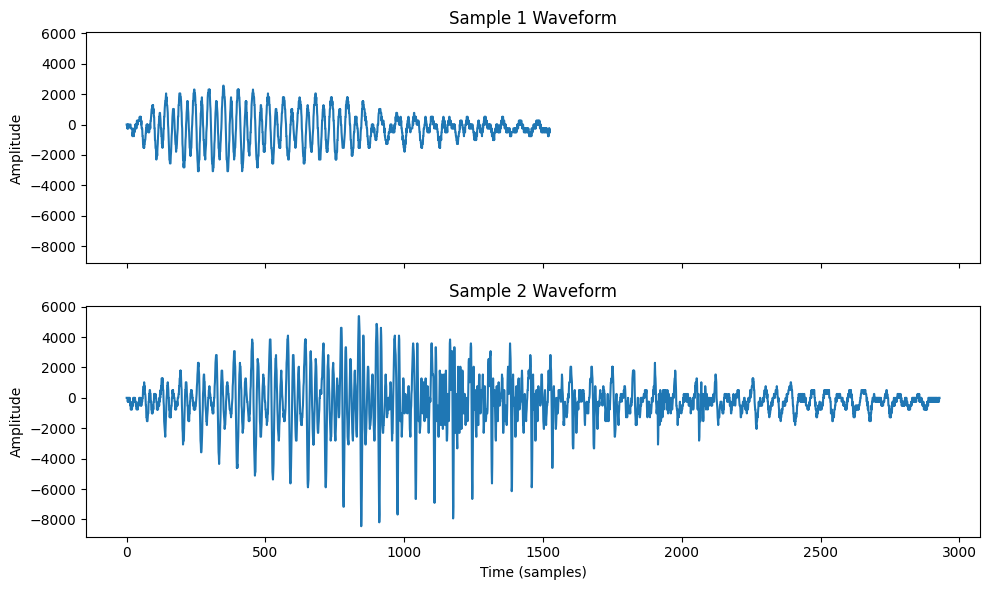

In [4]:
# Waveform Visualization
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
for i, item in enumerate(ds.take(2)):
    audio = item['audio'].numpy()
    times = np.arange(len(audio))
    axs[i].plot(times, audio)
    axs[i].set_title(f"Sample {i+1} Waveform")
    axs[i].set_ylabel("Amplitude")
axs[-1].set_xlabel("Time (samples)")

plt.tight_layout()
plt.show()

In [5]:
# Collect the audio data
x_data = []
y_data = []

for example in ds:
    audio = torch.from_numpy(example['audio'].numpy()).type(torch.float32)
    label = torch.tensor(example['label'].numpy())
    x_data.append(audio)
    y_data.append(label)

2025-03-28 11:14:56.962319: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
# Padding

max_length = max(len(audio)for audio in x_data)

x_data_padded = []

for audio in x_data:
    padding = max_length - len(audio)
    padded_audio = F.pad(audio, (0, padding), "constant", 0.0)
    x_data_padded.append(padded_audio)

x_data_padded[0].shape

torch.Size([18262])

In [7]:
scaler = Normalizer()
x_data_padded_scaled = scaler.fit_transform(x_data_padded)

In [8]:
print(f"min(x_data_padded_scaled[0]): {min(x_data_padded_scaled[0])}")
print(f"max(x_data_padded_scaled[0]): {max(x_data_padded_scaled[0])}")


min(x_data_padded_scaled[0]): -0.07279147207736969
max(x_data_padded_scaled[0]): 0.060659561306238174


In [9]:
# Display original audio examples

for i in range(2):
  waveform = x_data_padded[i]

  print('Waveform shape:', waveform.shape)
  print('Audio playback')
  display(Audio(waveform, rate=8000))

Waveform shape: torch.Size([18262])
Audio playback


Waveform shape: torch.Size([18262])
Audio playback


In [10]:
# Display scaled audio examples

for i in range(2):
  waveform = x_data_padded_scaled[i]

  print('Waveform shape:', waveform.shape)
  print('Audio playback')
  display(Audio(waveform, rate=8000))

Waveform shape: (18262,)
Audio playback


Waveform shape: (18262,)
Audio playback


In [11]:
# Train/test split

split_ratio = 0.7

num_train_samples = int(split_ratio * len(x_data))

x_train = torch.tensor(x_data_padded_scaled[:num_train_samples], device=device, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_data[:num_train_samples], device=device)

x_test = torch.tensor(x_data_padded_scaled[num_train_samples:], device=device, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_data[num_train_samples:], device=device)

batch_size = 64
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# input shape: (batch size, feature dimension, timesteps)
for batch_idx, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 1, 18262])
torch.Size([64])


In [12]:
class Model(nn.Module):
    def __init__(self, input_channel, hidden_channel, output_dim):
        super(Model, self).__init__()
        self.conv1 = nn.Conv1d(input_channel, hidden_channel[0], kernel_size=64, stride=2, padding=1)
        self.maxpool1 = nn.MaxPool1d(kernel_size=8, stride=8)
        self.conv2 = nn.Conv1d(hidden_channel[0], hidden_channel[1], kernel_size=64, stride=2, padding=1)
        self.maxpool2 = nn.MaxPool1d(kernel_size=8, stride=8)
        self.fc1 = nn.Linear(2144, output_dim)
        self.flatten = nn.Flatten()
        self.output_layer = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.output_layer(x)
        return x

In [13]:
input_channel = 1
hidden_channel = [16, 32]
output_dim = 10
lr = 1e-3
n_epochs = 100

model = Model(input_channel=input_channel, hidden_channel=hidden_channel, output_dim=output_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model

Model(
  (conv1): Conv1d(1, 16, kernel_size=(64,), stride=(2,), padding=(1,))
  (maxpool1): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(64,), stride=(2,), padding=(1,))
  (maxpool2): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2144, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (output_layer): LogSoftmax(dim=1)
)

In [14]:
# training

model.train()

for epoch in range(n_epochs):
    overall_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = F.nll_loss(y_pred, y)
        overall_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{n_epochs} Average Loss: {overall_loss / (batch_idx*batch_size)}")

Epoch 1/100 Average Loss: 0.037467473496993385
Epoch 2/100 Average Loss: 0.0367356033788787
Epoch 3/100 Average Loss: 0.03199182361088417
Epoch 4/100 Average Loss: 0.025905189138871652
Epoch 5/100 Average Loss: 0.02156605771570294
Epoch 6/100 Average Loss: 0.019185544026118738
Epoch 7/100 Average Loss: 0.01756359926528401
Epoch 8/100 Average Loss: 0.016354021685266937
Epoch 9/100 Average Loss: 0.015854035711122885
Epoch 10/100 Average Loss: 0.014320527927743064
Epoch 11/100 Average Loss: 0.013682051734239966
Epoch 12/100 Average Loss: 0.0131761038813878
Epoch 13/100 Average Loss: 0.012894365936517715
Epoch 14/100 Average Loss: 0.012367586777717978
Epoch 15/100 Average Loss: 0.011700953770842817
Epoch 16/100 Average Loss: 0.011547805017067326
Epoch 17/100 Average Loss: 0.010967389576964907
Epoch 18/100 Average Loss: 0.010416569257224048
Epoch 19/100 Average Loss: 0.01001663528451765
Epoch 20/100 Average Loss: 0.009873645707826924
Epoch 21/100 Average Loss: 0.009430812637287157
Epoch 22/

In [15]:
model.eval()

correct = 0
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(tqdm(test_loader)):
        y_pred = model(x).argmax(dim=1)
        correct += (y_pred == y).sum().item()

print(f"Test Accuracy: {correct / len(y_test)}")

100%|██████████| 12/12 [00:00<00:00, 33.06it/s]

Test Accuracy: 0.8586666666666667
